# Variational Quantum Eigensolver(VQE) using arbitrary ansatz

When performing chemical calculations in VQE, the unitary matrix is operated on the initial wavefunction states, such as Hartree-Fock wave functions. And the unitary operation is determined by the ansatz to be used. This time, we will calculate the electronic state of hydrogen molecule by VQE using ansatz that we made by ourselves. We will use Hardware Efficient Ansatz(HEA).

Install the necessary libraries. The Hamiltonian is obtained with OpenFermion.

In [ ]:
!pip3 install blueqat openfermion

Import the necessary libraries. The optimization of VQE uses SciPy minimize.

In [8]:
from blueqat import Circuit
from openfermion.hamiltonians import MolecularData
from openfermion.transforms import get_fermion_operator, jordan_wigner, get_sparse_operator
import numpy as np
from scipy.optimize import minimize

## Definition of Ansatz
We choose Hardware Efficient Ansatz (HEA). In HEA, firstly Ry and Rz gates operate to each initialized qubit, and then CZ gates connect the adjacent qubits to each other. This block consisting of Ry, Rz, and CZ gates is repeated several times. (It is noticed that the types of gates and the connections are slightly different depending on studies.) Physically, this ansatz can be interpreted as a combination of the change of state for each qubit using the rotation on the Bloch sphere by the Ry and Rz gates and the extension of the search space of the wave function using the CZ gate.
The arguments are the number of qubits n_qubits and the gate depth n_depth. The wave function is initialized in this function.

In [9]:
def HEA(params,n_qubits,n_depth):
    #Wave function initialization |1100>
    circ=Circuit().x[2, 3]

    #Circuit creation
    params_devided=np.array_split(params,n_depth)
    for params_one_depth in params_devided:
        for i,param in enumerate(params_one_depth):
            if i < n_qubits:
                circ.ry(param)[i]
            else:
                circ.rz(param)[i%n_qubits]
        for qbit in range(n_qubits):
            if qbit < n_qubits-1:
                circ.cz[qbit,qbit+1]
    
    #Running the circuit
    wf = circ.run(backend="numpy")
    return wf

## Expectations and cost functions
Get the expected value from the obtained wave function.

In [10]:
def expect(wf,hamiltonian):
    return np.vdot(wf, hamiltonian.dot(wf)).real

def cost(params,hamiltonian,n_qubits,n_depth):
    wf=HEA(params,n_qubits,n_depth)
    return expect(wf,hamiltonian)

## Obtaining the information of molecule
Specify the bond length of the hydrogen molecule and use OpenFermion to obtain information about the molecule. The basis set is STO-3G.

In [11]:
def get_molecule(length):
    geometry = [('H',(0.,0.,0.)),('H',(0.,0.,length))]
    try:
        description = f'{length:.2f}'
        molecule = MolecularData(geometry, "sto-3g",1,description=description)
        molecule.load()
    except:
        description = f'{length:.1f}'
        molecule = MolecularData(geometry, "sto-3g",1,description=description)
        molecule.load()
    return molecule

## Calculation Execution and Plotting
Run a VQE on each bond length (this takes a few minutes). We then compare the results of the VQE and Full CI (FCI) calculations with respect to energy and bond length.

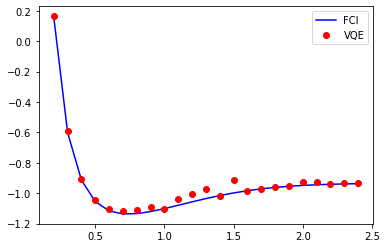

In [12]:
#Recording of bond length, HEA and FCI results
bond_len_list = [];energy_list=[];fullci_list=[]
#Execute the calculation for each bond length
for bond_len in np.arange(0.2,2.5,0.1):
    molecule = get_molecule(bond_len)
    #Determination of the number of bits, depth and initial parameter values
    n_qubits=molecule.n_qubits
    n_depth=4
    init_params=np.random.rand(2*n_qubits*n_depth)*0.1
    #Hamiltonian Definition
    hamiltonian = get_sparse_operator(jordan_wigner(get_fermion_operator(molecule.get_molecular_hamiltonian())))
    #Optimization run
    result=minimize(cost,x0=init_params,args=(hamiltonian,n_qubits,n_depth))
    #Recording of bond length, HEA and FCI results
    bond_len_list.append(bond_len)
    energy_list.append(result.fun)
    fullci_list.append(molecule.fci_energy)

#Plotting
import matplotlib.pyplot as plt
plt.plot(bond_len_list,fullci_list,label="FCI",color="blue")
plt.plot(bond_len_list,energy_list, marker="o",label="VQE",color="red",linestyle='None')
plt.legend()

While depending on the initial parameters,  VQE energy tends to deviate from the FCI energy in the large bond length region. The reason is that the prepared initial wavefunctions become different from the true solution with increasing the bond length. The accuracy might be improved by changing the initial parameters, ansatz, etc.